## **Spatio-Temporal Beam-Level Traffic Forecasting Challenge by ITU**
The objective of this challenge is to develop a multivariate time series forecasting model for traffic volume (DLThpVol) at the beam level.
* 2880 beams across 30 base stations
* each base station consists of 3 cells with 32 beams , with data recorded hourly
* dataset encompasses a five week period with data recorded at hourly intervals

* datasets:
    * traffic_DLThpVol.csv: represents throughput volume.
    * traffic_DLThpTime.csv: represents throughput time.
    * traffic_ DLPRB.csv: represents Physical Resource Block (PRB) utilization.
    * traffic_MR_number.csv: represents user count.

### **Notebook Objective**
* Catboost Modelling with the feature engineered data in the previous stage

### **Note**
* This notebook requires **high ram** due to the large datasets and takes nearly 10hrs to train and requires a **GPU**


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 23.1 MB/s eta 0:00:00


In [ ]:
import random
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

import catboost as catt

import torch


import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 500
pd.options.display.max_rows = 600

In [ ]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value)
# cpu  vars
    random.seed(seed_value)
 # Python
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
# gpu vars
        torch.backends.cudnn.deterministic = True
 #needed
        torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

random_seed(42,True)

### **Data Loading**

In [ ]:
path = '/content/gdrive/MyDrive/spatio_temporal/prepared_data/'

In [ ]:
encoded_train_df = pd.read_parquet(path + 'encoded_train_final.parquet').drop(columns = [] )
encoded_test_df = pd.read_parquet(path + 'encoded_test_final.parquet').drop(columns = [])

### **Memory Reduction**

In [ ]:
def convert_types(df):
    # Convert data types to reduce memory
    for c in df:
        col_type = str(df[c].dtypes)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

        # Convert objects to category
        if col_type == 'object':
            df[c] = df[c].astype('category')

        # numerics
        elif col_type in numerics:
            c_min = df[c].min()
            c_max = df[c].max()
            if col_type[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[c] = df[c].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[c] = df[c].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[c] = df[c].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[c] = df[c].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[c] = df[c].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[c] = df[c].astype(np.float32)
                else:
                    df[c] = df[c].astype(np.float64)

    return df
encoded_train_df = convert_types(encoded_train_df)
encoded_test_df = convert_types(encoded_test_df)

In [ ]:
encoded_train_df.head()

,ID,Target,week,hr,base_station,cell_type,beam,daily_hr,day,time,prb,mrno,fold,rolling_previous_Target_mean_336,rolling_previous_Target_median_336,rolling_previous_Target_std_336,rolling_previous_Target_0.25th_336,rolling_previous_Target_0.75th_336,rolling_previous_Target_mean_168,rolling_previous_Target_median_168,rolling_previous_Target_std_168,rolling_previous_Target_0.25th_168,rolling_previous_Target_0.75th_168,rolling_previous_Target_mean_7,rolling_previous_Target_median_7,rolling_previous_Target_std_7,rolling_previous_Target_0.25th_7,rolling_previous_Target_0.75th_7,rolling_previous_prb_mean_336,rolling_previous_prb_median_336,rolling_previous_prb_std_336,rolling_previous_prb_0.25th_336,rolling_previous_prb_0.75th_336,rolling_previous_prb_mean_168,rolling_previous_prb_median_168,rolling_previous_prb_std_168,rolling_previous_prb_0.25th_168,rolling_previous_prb_0.75th_168,rolling_previous_time_mean_336,rolling_previous_time_median_336,rolling_previous_time_std_336,rolling_previous_time_0.25th_336,rolling_previous_time_0.75th_336,rolling_previous_time_mean_168,rolling_previous_time_median_168,rolling_previous_time_std_168,rolling_previous_time_0.25th_168,rolling_previous_time_0.75th_168,expanding_base_station_beam_cell_type_Target_shift_168_mean,expanding_base_station_beam_cell_type_Target_shift_336_mean,expanding_base_station_beam_cell_type_Target_shift_504_mean,expanding_base_station_beam_cell_type_prb_shift_168_mean,expanding_base_station_beam_cell_type_prb_shift_336_mean,expanding_base_station_beam_cell_type_prb_shift_504_mean,expanding_base_station_beam_cell_type_mrno_shift_168_mean,expanding_base_station_beam_cell_type_mrno_shift_336_mean,expanding_base_station_beam_cell_type_mrno_shift_504_mean,expanding_base_station_beam_cell_type_time_shift_168_mean,expanding_base_station_beam_cell_type_time_shift_336_mean,expanding_base_station_beam_cell_type_time_shift_504_mean,previous_weekly_target_mean,previous_bs_beam_celltype_weekly_target_mean,Target_shifted_b_b_c_dh_1,Target_shifted_b_b_c_dh_2,Target_shifted_b_b_c_dh_3,Target_shifted_b_b_c_dh_4,mrno_shifted_b_b_c_dh_1,mrno_shifted_b_b_c_dh_2,mrno_shifted_b_b_c_dh_3,mrno_shifted_b_b_c_dh_4,prb_shifted_b_b_c_dh_1,prb_shifted_b_b_c_dh_2,prb_shifted_b_b_c_dh_3,prb_shifted_b_b_c_dh_4,Target_base_station_mean_te,Target_base_station_std_te,Target_base_station_skew_te,Target_base_station_min_te,Target_base_station_max_te,Target_base_station_25th_percentile_te,Target_base_station_75th_percentile_te,Target_base_station_95th_percentile_te,mrno_base_station_mean_te,mrno_base_station_std_te,mrno_base_station_skew_te,mrno_base_station_min_te,mrno_base_station_max_te,mrno_base_station_25th_percentile_te,mrno_base_station_75th_percentile_te,mrno_base_station_95th_percentile_te,prb_base_station_mean_te,prb_base_station_std_te,prb_base_station_skew_te,prb_base_station_min_te,prb_base_station_max_te,prb_base_station_25th_percentile_te,prb_base_station_75th_percentile_te,prb_base_station_95th_percentile_te,Target_hr_mean_te,Target_hr_std_te,Target_hr_skew_te,Target_hr_min_te,Target_hr_max_te,Target_hr_25th_percentile_te,Target_hr_75th_percentile_te,Target_hr_95th_percentile_te,mrno_hr_mean_te,mrno_hr_std_te,mrno_hr_skew_te,mrno_hr_min_te,mrno_hr_max_te,mrno_hr_25th_percentile_te,mrno_hr_75th_percentile_te,mrno_hr_95th_percentile_te,prb_hr_mean_te,prb_hr_std_te,prb_hr_skew_te,prb_hr_min_te,prb_hr_max_te,prb_hr_25th_percentile_te,prb_hr_75th_percentile_te,prb_hr_95th_percentile_te,Target_daily_hr_mean_te,Target_daily_hr_std_te,Target_daily_hr_skew_te,Target_daily_hr_min_te,Target_daily_hr_max_te,Target_daily_hr_25th_percentile_te,Target_daily_hr_75th_percentile_te,Target_daily_hr_95th_percentile_te,mrno_daily_hr_mean_te,mrno_daily_hr_std_te,mrno_daily_hr_skew_te,mrno_daily_hr_min_te,mrno_daily_hr_max_te,mrno_daily_hr_25th_percentile_te,mrno_daily_hr_75th_percentile_te,mrno_daily_hr_95th_percentile_te,prb_daily_hr_mean_te,prb_daily_hr_std_te,prb_daily_hr_skew_te,prb_daily_hr_min_te,prb_daily_hr_

### **Feature Selection and Modelling**

In [ ]:
def sqrt_transform(y):
    return np.sqrt(y)

def inverse_sqrt_transform(y):
    return np.square(y)
selected_columns_p =  ['daily_hr', 'hr', 'base_station', 'cell_type', 'beam',

                     'expanding_base_station_beam_cell_type_Target_shift_168_mean',
                    'expanding_base_station_beam_cell_type_Target_shift_336_mean',
                     'expanding_base_station_beam_cell_type_Target_shift_504_mean',

                     'expanding_base_station_beam_cell_type_prb_shift_168_mean',
                    'expanding_base_station_beam_cell_type_prb_shift_336_mean',
                    'expanding_base_station_beam_cell_type_prb_shift_504_mean',

                     'expanding_base_station_beam_cell_type_mrno_shift_168_mean',
                    'expanding_base_station_beam_cell_type_mrno_shift_336_mean',
                    'expanding_base_station_beam_cell_type_mrno_shift_504_mean',


                    'expanding_base_station_beam_cell_type_time_shift_168_mean',
                    'expanding_base_station_beam_cell_type_time_shift_336_mean',
                    'expanding_base_station_beam_cell_type_time_shift_504_mean',

                    ]+ [col for col in encoded_train_df.columns if 'previous' in col] + [col for col in encoded_train_df.columns if 'shifted' in col]

# drop_cols = [col for col in selected_columns_p if '_7'  in col]
drop_cols = []
# print(drop_cols)
selected_columns = [col for col in selected_columns_p if col not in drop_cols]
n_splits = encoded_train_df['fold'].nunique()
target_col = 'Target'
target_cols = ['Target','mrno', 'prb']
group_cols_list = [
    ['base_station'],
    ['hr'],
    ['daily_hr'],
    ['beam'],

    ['base_station', 'beam'],
    ['base_station', 'hr'],
    ['base_station', 'daily_hr'],
    ['base_station', 'cell_type'],
    ['base_station', 'cell_type', 'daily_hr'],
    ['base_station', 'cell_type', 'beam' ],
    ['base_station', 'cell_type', 'beam',  'daily_hr'],
    ['base_station', 'cell_type','beam',  'day'],
    ['base_station', 'beam', 'daily_hr'],


    ['beam', 'daily_hr'],
    ['beam', 'cell_type'],
    ['beam', 'cell_type', 'daily_hr'],

]
stats_to_use = ['mean', 'std', 'skew', 'min', 'max', '25th_percentile', '75th_percentile','95th_percentile']
# Initializing the OOF and fold predictions for both approaches
oof_preds_1 = np.zeros(len(encoded_train_df))
oof_preds_2 = np.zeros(len(encoded_train_df))
fold_pred_1 = []
fold_pred_2 = []

mae_approach_1 = []
mae_approach_2 = []


### **Modelling**
This code trains two Catboost models using different feature subsets for **time-series regression** with **cross-validation**. The task involves two approaches to handle short-term and long-term predictions.

#### **Key Elements:**
1. **Catboost Models**:
   - **Approach 1**: `cat_params` (with 15,000 estimators).
   - **Approach 2**: `cat_params` (with 15,000 estimators).
   - Both models use **MAE** as the objective and include GPU acceleration (`device='gpu'`).

2. **Target Transformation**:
   - Square root transformation is applied to the target variable for both training and predictions to stabilize variance.

3. **Feature Selection**:
   - **Approach 1**: Excludes lagged, expanding, and rolling features.
   - **Approach 2**: Includes all available features, including lag and expanding.

4. **Model Training & Validation**:
   - For each fold, two models are trained:
     - **Model 1** (Approach 1) on a subset of features for week 11
     - **Model 2** (Approach 2) on the full feature set for week 6
   - Predictions are made using the best iteration for each model, followed by an inverse square root transformation.

5. **Performance Evaluation**:
   - **MAE** is calculated for both approaches per fold, and **OOF (Out-Of-Fold)** predictions are stored.
   - Average MAE across all folds is computed for both approaches.

6. **Test Predictions**:
   - **Week 6** (immediate prediction): Uses Approach 2 (lag/expanding features).
   - **Week 11** (5-week gap): Uses Approach 1 (excludes lag/expanding features due to data becoming stale).

#### **Concept of Feature Subset Usage:**
- **Week 6**: Lagged, rolling, and expanding features are useful due to proximity to the training period.
- **Week 11**: Lagged/expanding features are excluded since the large gap (5 weeks) diminishes their relevance, avoiding stale data.

#### **Why This Strategy Is Effective:**
- **Short-term predictions** (like Week 6) benefit from incorporating recent data (lag, rolling, expanding) since recent trends are still impactful.
- **Long-term predictions** (like Week 11) should avoid relying on older data, which may no longer reflect the current state of the system. By excluding these features, the model avoids introducing irrelevant or outdated information.


In [ ]:
cat_params = {'learning_rate': 0.020218465729343698, 'depth': 9, 'l2_leaf_reg': 1.339103723284128e-06, 'random_strength': 6.000809910512735e-07, 'bagging_temperature': 0.38040823680407604, 'leaf_estimation_iterations': 7, 'iterations': 15000}
lgb_params = {'learning_rate': 0.06107031734204767, 'num_leaves': 151, 'max_depth': 8, 'feature_fraction': 0.7385191124705888, 'bagging_fraction': 0.998648903775685, 'bagging_freq': 8, 'min_child_samples': 10, 'lambda_l1': 1.011561569386919e-08, 'lambda_l2': 1.2665653189223212e-08, 'objective': 'mae'}
lgb_params_2_approach_1 = {'learning_rate': 0.02053584056236377, 'num_leaves': 254, 'max_depth': 10, 'feature_fraction': 0.6696720940035359, 'bagging_fraction': 0.7228804381516678, 'bagging_freq': 8, 'min_child_samples': 100, 'lambda_l1': 2.4850576136378315e-06, 'lambda_l2': 1.694355465523766e-08, 'n_estimators': 1000}
lgb_params_2_approach_2 = {'learning_rate': 0.08304613332693336, 'num_leaves': 151, 'max_depth': 9, 'feature_fraction': 0.7095128621678289, 'bagging_fraction': 0.9361601754529758, 'bagging_freq': 1, 'min_child_samples': 22, 'lambda_l1': 6.421772454121583e-07, 'lambda_l2': 0.0034348407467305964, 'n_estimators': 5000}
for fold in range(n_splits):
    print(f"Processing fold {fold+1}/{n_splits}")
    training = encoded_train_df[encoded_train_df['fold'] != fold]
    validation = encoded_train_df[encoded_train_df['fold'] == fold]

    # Apply sqrt transformation to the target
    y_train = sqrt_transform(training[target_col])
    y_test = sqrt_transform(validation[target_col])

    encoded_columns = [f"{target_col}_{'_'.join(cols)}_{stat}_te"
                       for target_col in target_cols
                       for cols in group_cols_list
                       for stat in stats_to_use]

    columns_approach_one = [col for col in selected_columns if 'shifted' not in col and 'previous' not in col and 'expanding' not in col]
    columns_approach_two = selected_columns
    print(columns_approach_one)
    print(columns_approach_two)

    X_train_1 = training[columns_approach_one + [col for col in encoded_columns if 'percentile' not in col]]
    X_test_1 = validation[columns_approach_one + [col for col in encoded_columns if 'percentile' not in col]]

    X_train_2 = training[columns_approach_two + encoded_columns]
    X_test_2 = validation[columns_approach_two + encoded_columns]

    # Train model for Approach 1
    model_1 = catt.CatBoostRegressor(**cat_params,
                                        loss_function = 'MAE',
                                        eval_metric = 'MAE',
                                        verbose = False,
                                        task_type = 'GPU'
                                    )
    model_1.fit(X_train_1, y_train, eval_set=(X_test_1, y_test), verbose=2500)

    # Train model for Approach 2
    model_2 = catt.CatBoostRegressor(**cat_params,
                                        loss_function = 'MAE',
                                        eval_metric = 'MAE',
                                        verbose = False,
                                        task_type = 'GPU'
                                    )
    model_2.fit(X_train_2, y_train, eval_set=(X_test_2, y_test), verbose=2500)

    # Make predictions for both approaches
    preds_1 = inverse_sqrt_transform(model_1.predict(X_test_1))
    preds_2 = inverse_sqrt_transform(model_2.predict(X_test_2))
    y_test_original = inverse_sqrt_transform(y_test)

    # Store OOF predictions
    oof_preds_1[validation.index] = preds_1
    oof_preds_2[validation.index] = preds_2

    # Calculate MAE for both approaches
    mae_1 = mean_absolute_error(y_test_original, preds_1)
    mae_2 = mean_absolute_error(y_test_original, preds_2)
    print(f"MAE for Approach 1, Fold {fold}: {mae_1}")
    print(f"MAE for Approach 2, Fold {fold}: {mae_2}")
    print("-"* 100)

    mae_approach_1.append(mae_1)
    mae_approach_2.append(mae_2)



    preds_test_1 = inverse_sqrt_transform(model_1.predict(encoded_test_df[encoded_test_df['week'] == 11][columns_approach_one +  [col for col in encoded_columns if 'percentile' not in col]]))
    preds_test_2 = inverse_sqrt_transform(model_2.predict(encoded_test_df[encoded_test_df['week'] == 6][columns_approach_two + encoded_columns]))

    fold_pred_1.append(preds_test_1)
    fold_pred_2.append(preds_test_2)

# Print overall MAE for both approaches
print(f"Average MAE for Approach 1: {np.mean(mae_approach_1)}")
print(f"Average MAE for Approach 2: {np.mean(mae_approach_2)}")

# # Add OOF predictions to the original train DataFrame
encoded_train_df['oof_preds_1'] = oof_preds_1
encoded_train_df['oof_preds_2'] = oof_preds_2


Processing fold 1/10
['daily_hr', 'hr', 'base_station', 'cell_type', 'beam']
['daily_hr', 'hr', 'base_station', 'cell_type', 'beam', 'expanding_base_station_beam_cell_type_Target_shift_168_mean', 'expanding_base_station_beam_cell_type_Target_shift_336_mean', 'expanding_base_station_beam_cell_type_Target_shift_504_mean', 'expanding_base_station_beam_cell_type_prb_shift_168_mean', 'expanding_base_station_beam_cell_type_prb_shift_336_mean', 'expanding_base_station_beam_cell_type_prb_shift_504_mean', 'expanding_base_station_beam_cell_type_mrno_shift_168_mean', 'expanding_base_station_beam_cell_type_mrno_shift_336_mean', 'expanding_base_station_beam_cell_type_mrno_shift_504_mean', 'expanding_base_station_beam_cell_type_time_shift_168_mean', 'expanding_base_station_beam_cell_type_time_shift_336_mean', 'expanding_base_station_beam_cell_type_time_shift_504_mean', 'rolling_previous_Target_mean_336', 'rolling_previous_Target_median_336', 'rolling_previous_Target_std_336', 'rolling_previous_Targe

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2968656	test: 0.2967673	best: 0.2967673 (0)	total: 138ms	remaining: 34m 29s
2500:	learn: 0.2031083	test: 0.2066245	best: 0.2066241 (2495)	total: 3m 8s	remaining: 15m 43s
5000:	learn: 0.2016385	test: 0.2066100	best: 0.2066028 (3705)	total: 6m 24s	remaining: 12m 48s
7500:	learn: 0.2007724	test: 0.2066044	best: 0.2066028 (3705)	total: 9m 32s	remaining: 9m 32s
10000:	learn: 0.1997570	test: 0.2065763	best: 0.2065761 (9965)	total: 12m 43s	remaining: 6m 21s
12500:	learn: 0.1988015	test: 0.2065358	best: 0.2065358 (12500)	total: 15m 55s	remaining: 3m 11s
14999:	learn: 0.1978566	test: 0.2064981	best: 0.2064977 (14980)	total: 19m 12s	remaining: 0us
bestTest = 0.2064976929
bestIteration = 14980
Shrink model to first 14981 iterations.


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2967958	test: 0.2967000	best: 0.2967000 (0)	total: 203ms	remaining: 50m 47s
2500:	learn: 0.2004424	test: 0.2038524	best: 0.2038524 (2500)	total: 4m 49s	remaining: 24m 5s
5000:	learn: 0.1985204	test: 0.2037426	best: 0.2037421 (4960)	total: 10m	remaining: 19m 59s
7500:	learn: 0.1974592	test: 0.2037119	best: 0.2037116 (7470)	total: 15m 3s	remaining: 15m 3s
10000:	learn: 0.1963348	test: 0.2036300	best: 0.2036300 (10000)	total: 20m 14s	remaining: 10m 6s
12500:	learn: 0.1953449	test: 0.2035582	best: 0.2035582 (12500)	total: 25m 14s	remaining: 5m 2s
14999:	learn: 0.1942704	test: 0.2034951	best: 0.2034950 (14995)	total: 30m 26s	remaining: 0us
bestTest = 0.2034950377
bestIteration = 14995
Shrink model to first 14996 iterations.
MAE for Approach 1, Fold 0: 0.19645743721751274
MAE for Approach 2, Fold 0: 0.1913425826980511
----------------------------------------------------------------------------------------------------
Processing fold 2/10
['daily_hr', 'hr', 'base_station', 'cell_t

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2968137	test: 0.2972389	best: 0.2972389 (0)	total: 131ms	remaining: 32m 51s
2500:	learn: 0.2030089	test: 0.2075082	best: 0.2075082 (2500)	total: 3m 12s	remaining: 16m
5000:	learn: 0.2016610	test: 0.2074973	best: 0.2074819 (4055)	total: 6m 27s	remaining: 12m 54s
7500:	learn: 0.2007415	test: 0.2074939	best: 0.2074819 (4055)	total: 9m 41s	remaining: 9m 40s
10000:	learn: 0.1997598	test: 0.2074407	best: 0.2074407 (10000)	total: 12m 54s	remaining: 6m 27s
12500:	learn: 0.1988122	test: 0.2073959	best: 0.2073959 (12500)	total: 16m 6s	remaining: 3m 13s
14999:	learn: 0.1979201	test: 0.2073543	best: 0.2073540 (14975)	total: 19m 21s	remaining: 0us
bestTest = 0.207354042
bestIteration = 14975
Shrink model to first 14976 iterations.


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2967386	test: 0.2971625	best: 0.2971625 (0)	total: 184ms	remaining: 45m 52s
2500:	learn: 0.2002694	test: 0.2046361	best: 0.2046361 (2500)	total: 4m 51s	remaining: 24m 14s
5000:	learn: 0.1971809	test: 0.2043390	best: 0.2043386 (4985)	total: 9m 58s	remaining: 19m 56s
7500:	learn: 0.1960628	test: 0.2043153	best: 0.2043153 (7500)	total: 15m 5s	remaining: 15m 5s
10000:	learn: 0.1950055	test: 0.2042435	best: 0.2042435 (10000)	total: 20m 12s	remaining: 10m 6s
12500:	learn: 0.1940176	test: 0.2041942	best: 0.2041941 (12495)	total: 25m 18s	remaining: 5m 3s
14999:	learn: 0.1930466	test: 0.2041492	best: 0.2041485 (14965)	total: 30m 23s	remaining: 0us
bestTest = 0.2041485499
bestIteration = 14965
Shrink model to first 14966 iterations.
MAE for Approach 1, Fold 1: 0.19988226727737324
MAE for Approach 2, Fold 1: 0.19407410360577232
----------------------------------------------------------------------------------------------------
Processing fold 3/10
['daily_hr', 'hr', 'base_station', 'c

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2967710	test: 0.2974697	best: 0.2974697 (0)	total: 131ms	remaining: 32m 50s
2500:	learn: 0.2032067	test: 0.2067194	best: 0.2067194 (2500)	total: 3m 10s	remaining: 15m 52s
5000:	learn: 0.2019677	test: 0.2066905	best: 0.2066905 (5000)	total: 6m 20s	remaining: 12m 40s
7500:	learn: 0.2011104	test: 0.2066651	best: 0.2066646 (7450)	total: 9m 34s	remaining: 9m 33s
10000:	learn: 0.2000849	test: 0.2066238	best: 0.2066238 (10000)	total: 12m 49s	remaining: 6m 24s
12500:	learn: 0.1991639	test: 0.2065790	best: 0.2065789 (12480)	total: 15m 59s	remaining: 3m 11s
14999:	learn: 0.1982586	test: 0.2065324	best: 0.2065323 (14995)	total: 19m 12s	remaining: 0us
bestTest = 0.2065322634
bestIteration = 14995
Shrink model to first 14996 iterations.


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2967081	test: 0.2974083	best: 0.2974083 (0)	total: 194ms	remaining: 48m 30s
2500:	learn: 0.2004126	test: 0.2038969	best: 0.2038969 (2500)	total: 4m 51s	remaining: 24m 16s
5000:	learn: 0.1982498	test: 0.2037114	best: 0.2037100 (4790)	total: 9m 51s	remaining: 19m 41s
7500:	learn: 0.1973724	test: 0.2036942	best: 0.2036942 (7495)	total: 14m 42s	remaining: 14m 42s
10000:	learn: 0.1964699	test: 0.2036142	best: 0.2036141 (9995)	total: 19m 27s	remaining: 9m 43s
12500:	learn: 0.1954301	test: 0.2035354	best: 0.2035354 (12500)	total: 24m 28s	remaining: 4m 53s
14999:	learn: 0.1944137	test: 0.2034787	best: 0.2034785 (14995)	total: 29m 36s	remaining: 0us
bestTest = 0.2034784711
bestIteration = 14995
Shrink model to first 14996 iterations.
MAE for Approach 1, Fold 2: 0.19655935574182218
MAE for Approach 2, Fold 2: 0.1913713523591326
----------------------------------------------------------------------------------------------------
Processing fold 4/10
['daily_hr', 'hr', 'base_station', '

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2968898	test: 0.2965457	best: 0.2965457 (0)	total: 127ms	remaining: 31m 49s
2500:	learn: 0.2031587	test: 0.2070478	best: 0.2070478 (2500)	total: 3m 10s	remaining: 15m 53s
5000:	learn: 0.2015301	test: 0.2069581	best: 0.2069578 (4995)	total: 6m 12s	remaining: 12m 24s
7500:	learn: 0.2005411	test: 0.2069010	best: 0.2069008 (7480)	total: 9m 13s	remaining: 9m 13s
10000:	learn: 0.1995861	test: 0.2068594	best: 0.2068589 (9950)	total: 12m 25s	remaining: 6m 12s
12500:	learn: 0.1986115	test: 0.2068223	best: 0.2068223 (12500)	total: 15m 40s	remaining: 3m 8s
14999:	learn: 0.1975966	test: 0.2068018	best: 0.2068018 (14999)	total: 18m 58s	remaining: 0us
bestTest = 0.2068017707
bestIteration = 14999


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2968045	test: 0.2964611	best: 0.2964611 (0)	total: 202ms	remaining: 50m 29s
2500:	learn: 0.2004279	test: 0.2041984	best: 0.2041984 (2500)	total: 4m 49s	remaining: 24m 5s
5000:	learn: 0.1969751	test: 0.2037650	best: 0.2037650 (5000)	total: 9m 48s	remaining: 19m 37s
7500:	learn: 0.1959218	test: 0.2037064	best: 0.2037064 (7500)	total: 14m 42s	remaining: 14m 41s
10000:	learn: 0.1948659	test: 0.2036503	best: 0.2036503 (10000)	total: 19m 56s	remaining: 9m 57s
12500:	learn: 0.1938590	test: 0.2036033	best: 0.2036030 (12480)	total: 25m 3s	remaining: 5m
14999:	learn: 0.1928135	test: 0.2035636	best: 0.2035633 (14990)	total: 30m 13s	remaining: 0us
bestTest = 0.2035632906
bestIteration = 14990
Shrink model to first 14991 iterations.
MAE for Approach 1, Fold 3: 0.19771771152990159
MAE for Approach 2, Fold 3: 0.1919998208793789
----------------------------------------------------------------------------------------------------
Processing fold 5/10
['daily_hr', 'hr', 'base_station', 'cell_

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2969777	test: 0.2959102	best: 0.2959102 (0)	total: 130ms	remaining: 32m 26s
2500:	learn: 0.2033128	test: 0.2063219	best: 0.2063219 (2500)	total: 3m 11s	remaining: 15m 54s
5000:	learn: 0.2020755	test: 0.2062836	best: 0.2062835 (4995)	total: 6m 24s	remaining: 12m 48s
7500:	learn: 0.2011498	test: 0.2062740	best: 0.2062733 (7375)	total: 9m 36s	remaining: 9m 36s
10000:	learn: 0.2001190	test: 0.2062430	best: 0.2062430 (10000)	total: 12m 45s	remaining: 6m 22s
12500:	learn: 0.1991632	test: 0.2061979	best: 0.2061979 (12500)	total: 15m 55s	remaining: 3m 10s
14999:	learn: 0.1982539	test: 0.2061540	best: 0.2061537 (14990)	total: 19m 9s	remaining: 0us
bestTest = 0.2061536678
bestIteration = 14990
Shrink model to first 14991 iterations.


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2968924	test: 0.2958277	best: 0.2958277 (0)	total: 186ms	remaining: 46m 31s
2500:	learn: 0.2004296	test: 0.2036322	best: 0.2036318 (2490)	total: 4m 50s	remaining: 24m 11s
5000:	learn: 0.1978846	test: 0.2033839	best: 0.2033839 (5000)	total: 9m 59s	remaining: 19m 59s
7500:	learn: 0.1967753	test: 0.2033590	best: 0.2033590 (7500)	total: 15m 7s	remaining: 15m 7s
10000:	learn: 0.1957376	test: 0.2032759	best: 0.2032758 (9990)	total: 20m 6s	remaining: 10m 3s
12500:	learn: 0.1946742	test: 0.2032200	best: 0.2032200 (12500)	total: 25m 9s	remaining: 5m 1s
14999:	learn: 0.1936701	test: 0.2031655	best: 0.2031650 (14960)	total: 30m 19s	remaining: 0us
bestTest = 0.2031649635
bestIteration = 14960
Shrink model to first 14961 iterations.
MAE for Approach 1, Fold 4: 0.19480600406627493
MAE for Approach 2, Fold 4: 0.18962548399974222
----------------------------------------------------------------------------------------------------
Processing fold 6/10
['daily_hr', 'hr', 'base_station', 'cell

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2967957	test: 0.2973021	best: 0.2973021 (0)	total: 125ms	remaining: 31m 20s
2500:	learn: 0.2031889	test: 0.2074522	best: 0.2074522 (2500)	total: 3m 10s	remaining: 15m 54s
5000:	learn: 0.2019303	test: 0.2073812	best: 0.2073808 (4970)	total: 6m 17s	remaining: 12m 34s
7500:	learn: 0.2009001	test: 0.2073207	best: 0.2073207 (7495)	total: 9m 22s	remaining: 9m 22s
10000:	learn: 0.1998994	test: 0.2072544	best: 0.2072542 (9990)	total: 12m 36s	remaining: 6m 17s
12500:	learn: 0.1989096	test: 0.2072004	best: 0.2072004 (12500)	total: 15m 48s	remaining: 3m 9s
14999:	learn: 0.1978941	test: 0.2071333	best: 0.2071333 (14995)	total: 19m 4s	remaining: 0us
bestTest = 0.2071332659
bestIteration = 14995
Shrink model to first 14996 iterations.


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2967346	test: 0.2972364	best: 0.2972364 (0)	total: 187ms	remaining: 46m 44s
2500:	learn: 0.2003444	test: 0.2045130	best: 0.2045130 (2500)	total: 4m 48s	remaining: 24m
5000:	learn: 0.1973970	test: 0.2041628	best: 0.2041623 (4980)	total: 9m 40s	remaining: 19m 20s
7500:	learn: 0.1963306	test: 0.2041452	best: 0.2041441 (7380)	total: 14m 16s	remaining: 14m 16s
10000:	learn: 0.1953128	test: 0.2040945	best: 0.2040945 (9995)	total: 19m 12s	remaining: 9m 36s
12500:	learn: 0.1942742	test: 0.2040802	best: 0.2040766 (11550)	total: 23m 53s	remaining: 4m 46s
14999:	learn: 0.1931685	test: 0.2040467	best: 0.2040467 (14999)	total: 28m 50s	remaining: 0us
bestTest = 0.2040467439
bestIteration = 14999
MAE for Approach 1, Fold 5: 0.1975048478332567
MAE for Approach 2, Fold 5: 0.19190191488587782
----------------------------------------------------------------------------------------------------
Processing fold 7/10
['daily_hr', 'hr', 'base_station', 'cell_type', 'beam']
['daily_hr', 'hr', 'base

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2968650	test: 0.2967569	best: 0.2967569 (0)	total: 132ms	remaining: 32m 52s
2500:	learn: 0.2030477	test: 0.2072901	best: 0.2072901 (2500)	total: 3m 11s	remaining: 15m 55s
5000:	learn: 0.2012220	test: 0.2072055	best: 0.2072034 (4195)	total: 6m 15s	remaining: 12m 30s
7500:	learn: 0.2004125	test: 0.2071912	best: 0.2071904 (7195)	total: 9m 10s	remaining: 9m 10s
10000:	learn: 0.1995124	test: 0.2071832	best: 0.2071830 (9975)	total: 12m 19s	remaining: 6m 9s
12500:	learn: 0.1985998	test: 0.2071394	best: 0.2071393 (12480)	total: 15m 26s	remaining: 3m 5s
14999:	learn: 0.1977237	test: 0.2070825	best: 0.2070812 (14920)	total: 18m 34s	remaining: 0us
bestTest = 0.20708116
bestIteration = 14920
Shrink model to first 14921 iterations.


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2967813	test: 0.2966678	best: 0.2966678 (0)	total: 187ms	remaining: 46m 51s
2500:	learn: 0.2003635	test: 0.2044195	best: 0.2044195 (2500)	total: 4m 48s	remaining: 24m 2s
5000:	learn: 0.1974155	test: 0.2041110	best: 0.2041110 (5000)	total: 9m 56s	remaining: 19m 52s
7500:	learn: 0.1964298	test: 0.2041155	best: 0.2041103 (6540)	total: 15m 10s	remaining: 15m 10s
10000:	learn: 0.1954520	test: 0.2040917	best: 0.2040917 (10000)	total: 20m 17s	remaining: 10m 8s
12500:	learn: 0.1944027	test: 0.2040343	best: 0.2040343 (12470)	total: 25m 15s	remaining: 5m 2s
14999:	learn: 0.1934348	test: 0.2039866	best: 0.2039862 (14990)	total: 30m 15s	remaining: 0us
bestTest = 0.2039862254
bestIteration = 14990
Shrink model to first 14991 iterations.
MAE for Approach 1, Fold 6: 0.19783316015415897
MAE for Approach 2, Fold 6: 0.19226055850685406
----------------------------------------------------------------------------------------------------
Processing fold 8/10
['daily_hr', 'hr', 'base_station', '

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2968933	test: 0.2964743	best: 0.2964743 (0)	total: 128ms	remaining: 32m 2s
2500:	learn: 0.2030658	test: 0.2067283	best: 0.2067283 (2500)	total: 3m 11s	remaining: 15m 58s
5000:	learn: 0.2014566	test: 0.2066311	best: 0.2066311 (5000)	total: 6m 13s	remaining: 12m 27s
7500:	learn: 0.2004946	test: 0.2065846	best: 0.2065846 (7500)	total: 9m 19s	remaining: 9m 19s
10000:	learn: 0.1994723	test: 0.2065648	best: 0.2065640 (9605)	total: 12m 30s	remaining: 6m 14s
12500:	learn: 0.1984932	test: 0.2065377	best: 0.2065359 (12350)	total: 15m 39s	remaining: 3m 7s
14999:	learn: 0.1975687	test: 0.2065275	best: 0.2065274 (14985)	total: 18m 46s	remaining: 0us
bestTest = 0.206527387
bestIteration = 14985
Shrink model to first 14986 iterations.


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2968258	test: 0.2964096	best: 0.2964096 (0)	total: 189ms	remaining: 47m 13s
2500:	learn: 0.2002760	test: 0.2039422	best: 0.2039422 (2500)	total: 4m 50s	remaining: 24m 12s
5000:	learn: 0.1964269	test: 0.2035133	best: 0.2035133 (5000)	total: 9m 51s	remaining: 19m 43s
7500:	learn: 0.1949582	test: 0.2035120	best: 0.2034995 (6715)	total: 14m 33s	remaining: 14m 33s
10000:	learn: 0.1939356	test: 0.2034967	best: 0.2034964 (9995)	total: 19m 25s	remaining: 9m 42s
12500:	learn: 0.1928977	test: 0.2034749	best: 0.2034746 (12440)	total: 24m 3s	remaining: 4m 48s
14999:	learn: 0.1919153	test: 0.2034558	best: 0.2034558 (14999)	total: 28m 59s	remaining: 0us
bestTest = 0.2034558493
bestIteration = 14999
MAE for Approach 1, Fold 7: 0.19635334012092945
MAE for Approach 2, Fold 7: 0.19089501292201286
----------------------------------------------------------------------------------------------------
Processing fold 9/10
['daily_hr', 'hr', 'base_station', 'cell_type', 'beam']
['daily_hr', 'hr', '

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2968234	test: 0.2971895	best: 0.2971895 (0)	total: 127ms	remaining: 31m 50s
2500:	learn: 0.2034202	test: 0.2064460	best: 0.2064457 (2485)	total: 3m 9s	remaining: 15m 45s
5000:	learn: 0.2019512	test: 0.2063736	best: 0.2063735 (4995)	total: 6m 15s	remaining: 12m 30s
7500:	learn: 0.2009359	test: 0.2063218	best: 0.2063218 (7500)	total: 9m 22s	remaining: 9m 22s
10000:	learn: 0.2000432	test: 0.2062907	best: 0.2062907 (10000)	total: 12m 27s	remaining: 6m 13s
12500:	learn: 0.1990768	test: 0.2062669	best: 0.2062669 (12495)	total: 15m 47s	remaining: 3m 9s
14999:	learn: 0.1981271	test: 0.2062518	best: 0.2062518 (14999)	total: 19m 3s	remaining: 0us
bestTest = 0.2062518084
bestIteration = 14999


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2967383	test: 0.2971042	best: 0.2971042 (0)	total: 204ms	remaining: 50m 58s
2500:	learn: 0.2004281	test: 0.2037217	best: 0.2037217 (2500)	total: 4m 48s	remaining: 24m 1s
5000:	learn: 0.1965764	test: 0.2033008	best: 0.2033008 (5000)	total: 9m 49s	remaining: 19m 39s
7500:	learn: 0.1951509	test: 0.2032806	best: 0.2032799 (7060)	total: 14m 38s	remaining: 14m 37s
10000:	learn: 0.1941366	test: 0.2032850	best: 0.2032797 (7605)	total: 19m 34s	remaining: 9m 46s
12500:	learn: 0.1931106	test: 0.2032408	best: 0.2032408 (12500)	total: 24m 36s	remaining: 4m 55s
14999:	learn: 0.1921043	test: 0.2032171	best: 0.2032089 (14070)	total: 29m 35s	remaining: 0us
bestTest = 0.2032089476
bestIteration = 14070
Shrink model to first 14071 iterations.
MAE for Approach 1, Fold 8: 0.19592725324858723
MAE for Approach 2, Fold 8: 0.19055411284949983
----------------------------------------------------------------------------------------------------
Processing fold 10/10
['daily_hr', 'hr', 'base_station', 

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2968752	test: 0.2969299	best: 0.2969299 (0)	total: 129ms	remaining: 32m 21s
2500:	learn: 0.2030233	test: 0.2073069	best: 0.2073069 (2500)	total: 3m 12s	remaining: 15m 59s
5000:	learn: 0.2015111	test: 0.2072219	best: 0.2072215 (4990)	total: 6m 20s	remaining: 12m 41s
7500:	learn: 0.2005360	test: 0.2071883	best: 0.2071865 (7360)	total: 9m 32s	remaining: 9m 32s
10000:	learn: 0.1995816	test: 0.2071549	best: 0.2071549 (10000)	total: 12m 46s	remaining: 6m 23s
12500:	learn: 0.1986144	test: 0.2071005	best: 0.2071005 (12495)	total: 16m 1s	remaining: 3m 12s
14999:	learn: 0.1976674	test: 0.2070547	best: 0.2070547 (14999)	total: 19m 17s	remaining: 0us
bestTest = 0.2070547114
bestIteration = 14999


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2967971	test: 0.2968498	best: 0.2968498 (0)	total: 217ms	remaining: 54m 16s
2500:	learn: 0.2003381	test: 0.2046104	best: 0.2046104 (2500)	total: 4m 50s	remaining: 24m 10s
5000:	learn: 0.1975251	test: 0.2043260	best: 0.2043259 (4995)	total: 9m 53s	remaining: 19m 45s
7500:	learn: 0.1964666	test: 0.2042816	best: 0.2042815 (7475)	total: 14m 51s	remaining: 14m 51s
10000:	learn: 0.1953640	test: 0.2042128	best: 0.2042128 (10000)	total: 20m	remaining: 9m 59s
12500:	learn: 0.1942940	test: 0.2041524	best: 0.2041524 (12500)	total: 25m 5s	remaining: 5m
14999:	learn: 0.1932272	test: 0.2041047	best: 0.2041047 (14995)	total: 30m 18s	remaining: 0us
bestTest = 0.2041046627
bestIteration = 14995
Shrink model to first 14996 iterations.
MAE for Approach 1, Fold 9: 0.19901730026550218
MAE for Approach 2, Fold 9: 0.19374313832610257
----------------------------------------------------------------------------------------------------
Average MAE for Approach 1: 0.1972058677455319
Average MAE for A

### **Feature Importance**

Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

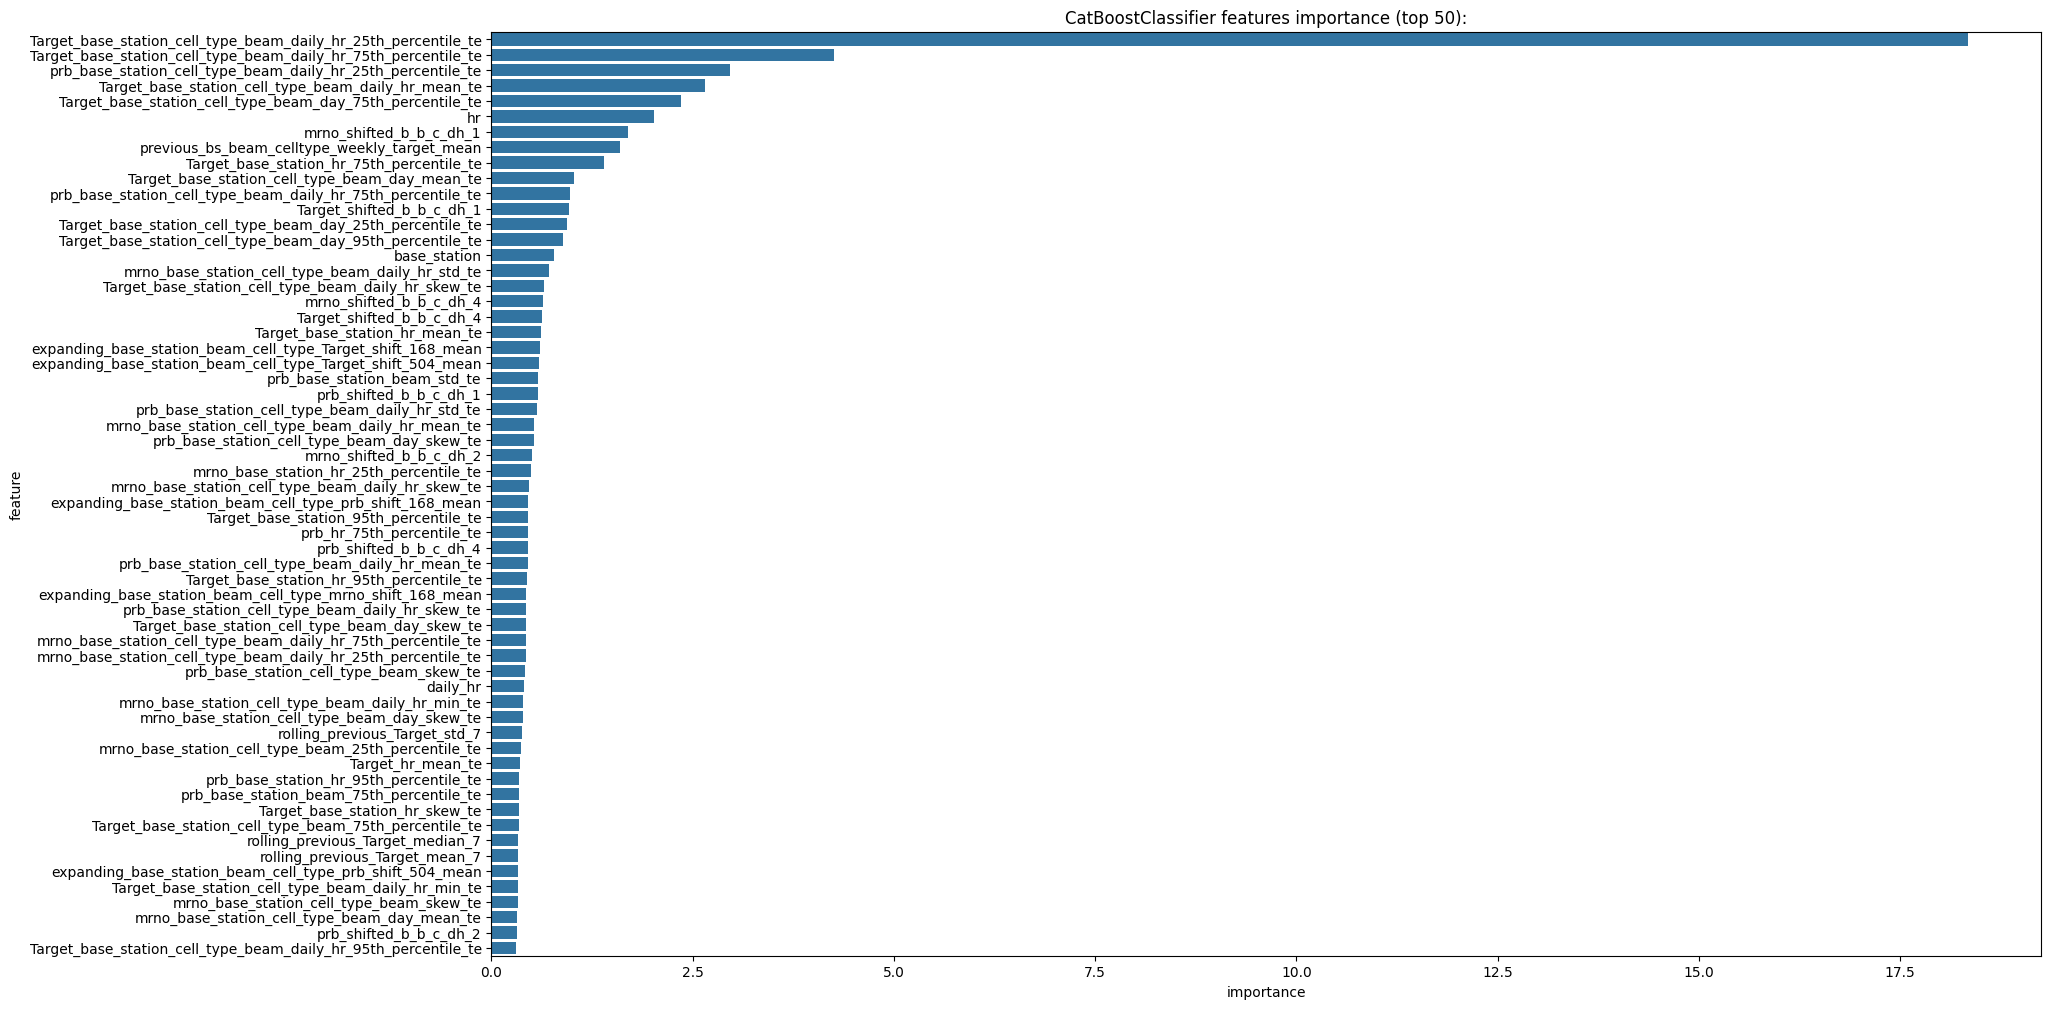

In [ ]:
feature_importance_df = pd.DataFrame(model_2.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = columns_approach_two + encoded_columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 50):')

### **Submission**


In [ ]:
# Predict for week 11 using Approach 1
week_11_preds = np.mean([pred for pred in fold_pred_1], axis=0)
week_11_test = encoded_test_df[encoded_test_df['week'] == 11].copy()
week_11_test['preds'] = week_11_preds

# Predict for week 6 using Approach 2
week_6_preds = np.mean([pred for pred in fold_pred_2], axis=0)
week_6_test = encoded_test_df[encoded_test_df['week'] == 6].copy()
week_6_test['preds'] = week_6_preds

# Concatenate the predictions
final_submission = pd.concat([week_11_test[['ID', 'preds']], week_6_test[['ID', 'preds']]])

# Optionally, save the submission to a CSV file
final_submission.to_csv(path + 'submission_catt_1917.csv', index=False)

# Preview the submission
display(final_submission.head())


,ID,preds
483840,traffic_DLThpVol_test_10w-11w_0_0_0_0,0.174305
483841,traffic_DLThpVol_test_10w-11w_0_0_0_1,0.003086
483842,traffic_DLThpVol_test_10w-11w_0_0_0_2,0.012583
483843,traffic_DLThpVol_test_10w-11w_0_0_0_3,0.003010
483844,traffic_DLThpVol_test_10w-11w_0_0_0_4,0.324311
